In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/FirstCompetition

/gdrive/My Drive/FirstCompetition


In [ ]:
#!pip install -r requirements.txt
!pip install visualkeras

     |████████████████████████████████| 795 kB 8.2 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# cose per valutare l'algorithm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import visualkeras

tfk = tf.keras
tfkl = tfk.layers

In [ ]:
# Random seed for reproducibility
seed = 333

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

##Creating the datasets

In [ ]:
dataset_base = 'dataset'
train_data_dir = dataset_base + '/training'
test_data_dir = dataset_base + '/test'

## Splitting in training dataset and validation dataset

In [ ]:
img_height = 256
img_width = 256

batch_size = 32
epochs = 500

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# preprocessing function to rescale the image getting valies within the interval [-1,1]
# we have to do so because Xception works with these values

def pre_process(img):
  return img/127.5 -1

In [ ]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.3, height_shift_range=0.3,
    zoom_range=0.2, channel_shift_range=0.2,
    horizontal_flip=True, vertical_flip=True,
    rotation_range=30,
    brightness_range=(0.8,1.2),
    preprocessing_function = pre_process,
    validation_split=0.1) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # set as validation data
    seed = seed)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # set as validation data
    seed = seed) 

Found 15171 images belonging to 14 classes.
Found 1678 images belonging to 14 classes.


In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('EricaTest') #modify the test folder
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

# Transfer learning

In [ ]:
input_shape = (256,256,3)

In [ ]:
# Import Xception base model
base_model = tfk.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_shape,
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.summary()
tfk.utils.plot_model(base_model)

In [ ]:
# freeze the base model
base_model.trainable = False

# qui già è differente da come ha fatto Luca

In [ ]:
# Create a new model on top

inputs = tfk.Input(shape=input_shape)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
x = tfkl.Resizing(image_h, image_w, interpolation='bicubic', name='Resize')

# flattering
x = tfkl.Flatten(name='Flattening')(x)

# classifier with dropout, dense (256), dropout, dense (14)
x = base_model(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    128,                                # cambiato da 256 a 128 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
model = tfk.Model(inputs, outputs, name='base_model')

In [ ]:
# compile the model on the new data
model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics='accuracy')
model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                1

In [ ]:
# create class weights
class_distr = []
for i in range(14):
  class_distr.append(sum(1 for x in train_generator.labels if x == i))
  
weights = []
total = train_generator.labels.size

for i in range(14):
  weights.append((i,(1/class_distr[i]) * (total/14.0)))

class_weight  = {cat:weight for (cat,weight) in weights}

In [ ]:
tf.autograph.set_verbosity(0)

callbacks = create_folders_and_callbacks(model_name='First_iteration')
batch_size= 32;
epochs=200;

# Train the model
tl_history = model.fit(
          x = train_generator,
          batch_size=batch_size,
          epochs = epochs,
          validation_data = validation_generator,
          class_weight=class_weight,
          callbacks = callbacks).history


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/200
475/475 [==============================] - ETA: 0s - loss: 2.0453 - accuracy: 0.4255INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 4311s 9s/step - loss: 2.0453 - accuracy: 0.4255 - val_loss: 1.6470 - val_accuracy: 0.5828
Epoch 2/200
475/475 [==============================] - ETA: 0s - loss: 1.3054 - accuracy: 0.5468INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 371s 780ms/step - loss: 1.3054 - accuracy: 0.5468 - val_loss: 1.2822 - val_accuracy: 0.6013
Epoch 3/200
475/475 [==============================] - ETA: 0s - loss: 1.1008 - accuracy: 0.6190INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 373s 785ms/step - loss: 1.1008 - accuracy: 0.6190 - val_loss: 1.2264 - val_accuracy: 0.6055
Epoch 4/200
475/475 [==============================] - ETA: 0s - loss: 0.9820 - accuracy: 0.6452INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 370s 779ms/step - loss: 0.9820 - accuracy: 0.6452 - val_loss: 1.1577 - val_accuracy: 0.6573
Epoch 5/200
475/475 [==============================] - ETA: 0s - loss: 0.9336 - accuracy: 0.6653INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 364s 767ms/step - loss: 0.9336 - accuracy: 0.6653 - val_loss: 1.1397 - val_accuracy: 0.6341
Epoch 6/200
475/475 [==============================] - ETA: 0s - loss: 0.8330 - accuracy: 0.6932INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 361s 759ms/step - loss: 0.8330 - accuracy: 0.6932 - val_loss: 0.9280 - val_accuracy: 0.7271
Epoch 7/200
475/475 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.6930INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 365s 769ms/step - loss: 0.8327 - accuracy: 0.6930 - val_loss: 0.9189 - val_accuracy: 0.7187
Epoch 8/200
475/475 [==============================] - ETA: 0s - loss: 0.7700 - accuracy: 0.7135INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 363s 763ms/step - loss: 0.7700 - accuracy: 0.7135 - val_loss: 0.8214 - val_accuracy: 0.7455
Epoch 9/200
475/475 [==============================] - ETA: 0s - loss: 0.7758 - accuracy: 0.7102INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 360s 757ms/step - loss: 0.7758 - accuracy: 0.7102 - val_loss: 1.0977 - val_accuracy: 0.6883
Epoch 10/200
475/475 [==============================] - ETA: 0s - loss: 0.8029 - accuracy: 0.7005INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 362s 761ms/step - loss: 0.8029 - accuracy: 0.7005 - val_loss: 0.8655 - val_accuracy: 0.7616
Epoch 11/200
475/475 [==============================] - ETA: 0s - loss: 0.7722 - accuracy: 0.7186INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 360s 757ms/step - loss: 0.7722 - accuracy: 0.7186 - val_loss: 0.9457 - val_accuracy: 0.7586
Epoch 12/200
475/475 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.7421INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 360s 758ms/step - loss: 0.7209 - accuracy: 0.7421 - val_loss: 0.8957 - val_accuracy: 0.7426
Epoch 13/200
475/475 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.7512INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 366s 771ms/step - loss: 0.6885 - accuracy: 0.7512 - val_loss: 0.8067 - val_accuracy: 0.7771
Epoch 14/200
475/475 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.7475INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 373s 785ms/step - loss: 0.6755 - accuracy: 0.7475 - val_loss: 0.6926 - val_accuracy: 0.8075
Epoch 15/200
475/475 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.7538INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 374s 787ms/step - loss: 0.6834 - accuracy: 0.7538 - val_loss: 0.7229 - val_accuracy: 0.7926
Epoch 16/200
475/475 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.7436INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 790ms/step - loss: 0.7046 - accuracy: 0.7436 - val_loss: 0.8438 - val_accuracy: 0.7741
Epoch 17/200
475/475 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.7562INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 372s 784ms/step - loss: 0.6539 - accuracy: 0.7562 - val_loss: 0.6916 - val_accuracy: 0.7920
Epoch 18/200
475/475 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7506INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 373s 785ms/step - loss: 0.6616 - accuracy: 0.7506 - val_loss: 0.8711 - val_accuracy: 0.7330
Epoch 19/200
475/475 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.7574INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 374s 788ms/step - loss: 0.6553 - accuracy: 0.7574 - val_loss: 0.7927 - val_accuracy: 0.7700
Epoch 20/200
475/475 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7565INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 789ms/step - loss: 0.6652 - accuracy: 0.7565 - val_loss: 0.6814 - val_accuracy: 0.7789
Epoch 21/200
475/475 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.7621INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 376s 792ms/step - loss: 0.6388 - accuracy: 0.7621 - val_loss: 0.7558 - val_accuracy: 0.7700
Epoch 22/200
475/475 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7662INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 376s 792ms/step - loss: 0.6165 - accuracy: 0.7662 - val_loss: 0.8302 - val_accuracy: 0.7676
Epoch 23/200
475/475 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.7686INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 378s 796ms/step - loss: 0.6205 - accuracy: 0.7686 - val_loss: 0.5394 - val_accuracy: 0.8415
Epoch 24/200
475/475 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.7642INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 376s 791ms/step - loss: 0.6224 - accuracy: 0.7642 - val_loss: 0.6586 - val_accuracy: 0.8021
Epoch 25/200
475/475 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.7779INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 374s 787ms/step - loss: 0.5955 - accuracy: 0.7779 - val_loss: 0.5554 - val_accuracy: 0.8319
Epoch 26/200
475/475 [==============================] - ETA: 0s - loss: 0.6075 - accuracy: 0.7736INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 789ms/step - loss: 0.6075 - accuracy: 0.7736 - val_loss: 0.7663 - val_accuracy: 0.7938
Epoch 27/200
475/475 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.7740INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 790ms/step - loss: 0.5686 - accuracy: 0.7740 - val_loss: 0.6173 - val_accuracy: 0.8057
Epoch 28/200
475/475 [==============================] - ETA: 0s - loss: 0.5798 - accuracy: 0.7817INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 790ms/step - loss: 0.5798 - accuracy: 0.7817 - val_loss: 0.7013 - val_accuracy: 0.7831
Epoch 29/200
475/475 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.7860INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 790ms/step - loss: 0.5727 - accuracy: 0.7860 - val_loss: 0.8362 - val_accuracy: 0.7396
Epoch 30/200
475/475 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.7864INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 376s 791ms/step - loss: 0.5711 - accuracy: 0.7864 - val_loss: 0.6780 - val_accuracy: 0.7932
Epoch 31/200
475/475 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7705INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 374s 788ms/step - loss: 0.5736 - accuracy: 0.7705 - val_loss: 0.6024 - val_accuracy: 0.8164
Epoch 32/200
475/475 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.7910INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 789ms/step - loss: 0.5610 - accuracy: 0.7910 - val_loss: 0.7976 - val_accuracy: 0.7706
Epoch 33/200
475/475 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.7876INFO:tensorflow:Assets written to: EricaTest/First_iteration_Nov20_15-58-36/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 790ms/step - loss: 0.5590 - accuracy: 0.7876 - val_loss: 0.6918 - val_accuracy: 0.7950


In [ ]:
model.save("EricaTest/First_iteration_Best")
model.save_weights("EricaTest/First_iteration_Best_weights")

INFO:tensorflow:Assets written to: EricaTest/First_iteration_Best/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


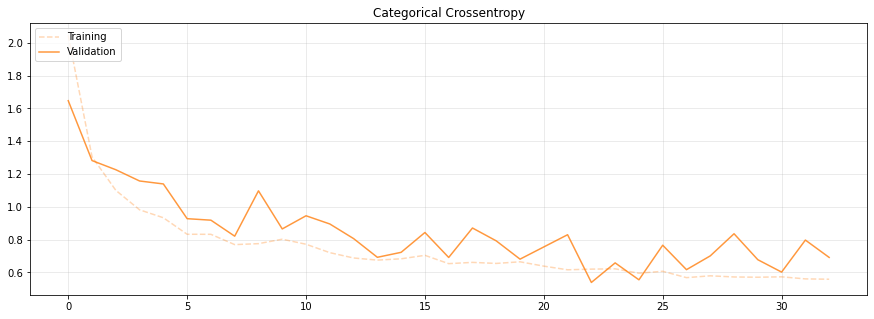

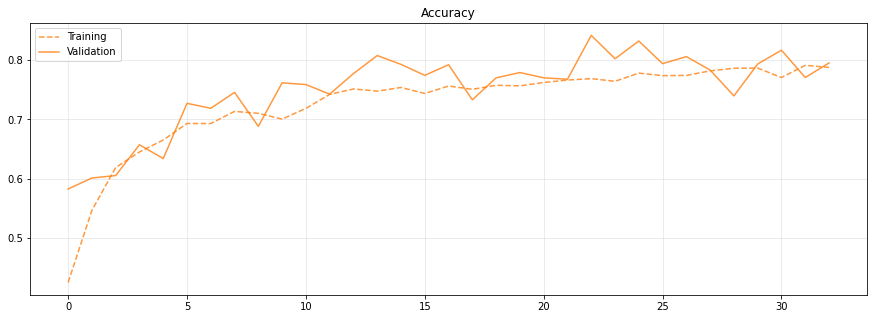

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Testing the model (not yet fine tuning)

In [ ]:
test_data_dir = 'dataset/test'

test_datagen = ImageDataGenerator(preprocessing_function = pre_process)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=1,
    shuffle=False,
    class_mode='categorical',
    seed = seed)

# Evaluate on test
model_totest = tfk.models.load_model('EricaTest/First_iteration_Best')
model_totest_test_metrics = model_totest.evaluate(test_generator, return_dict=True)

print()
print("Test metrics ")
print(model_totest_test_metrics)

Found 879 images belonging to 14 classes.
879/879 [==============================] - 140s 157ms/step - loss: 0.1520 - accuracy: 0.9556

Test metrics 
{'loss': 0.15199103951454163, 'accuracy': 0.9556313753128052}


## Fine - tuning

In [ ]:
# Unfreeze the base model
base_model.trainable = True

In [ ]:
# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=tfk.optimizers.Adam(1e-5),    # Very low learning rate#
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics='accuracy')
model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                1

In [ ]:
callbacks = create_folders_and_callbacks(model_name='FineTuning_callbacks')

epochs = 10
batch_size = 32

fine_tuning1_his = model.fit(
    x = train_generator,
    batch_size=batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks
).history

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/10
475/475 [==============================] - ETA: 0s - loss: 1.3284 - accuracy: 0.6287INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 392s 824ms/step - loss: 1.3284 - accuracy: 0.6287 - val_loss: 0.7039 - val_accuracy: 0.7741
Epoch 2/10
475/475 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7918INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 381s 801ms/step - loss: 0.6565 - accuracy: 0.7918 - val_loss: 0.5208 - val_accuracy: 0.8308
Epoch 3/10
475/475 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.8400INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 375s 789ms/step - loss: 0.4986 - accuracy: 0.8400 - val_loss: 0.3609 - val_accuracy: 0.8909
Epoch 4/10
475/475 [==============================] - ETA: 0s - loss: 0.4276 - accuracy: 0.8614INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 373s 784ms/step - loss: 0.4276 - accuracy: 0.8614 - val_loss: 0.3436 - val_accuracy: 0.8886
Epoch 5/10
475/475 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.8909INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 377s 792ms/step - loss: 0.3502 - accuracy: 0.8909 - val_loss: 0.2540 - val_accuracy: 0.9213
Epoch 6/10
475/475 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.9034INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 379s 796ms/step - loss: 0.2968 - accuracy: 0.9034 - val_loss: 0.2545 - val_accuracy: 0.9160
Epoch 7/10
475/475 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.9156INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 377s 792ms/step - loss: 0.2580 - accuracy: 0.9156 - val_loss: 0.2508 - val_accuracy: 0.9279
Epoch 8/10
475/475 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9251INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 378s 794ms/step - loss: 0.2316 - accuracy: 0.9251 - val_loss: 0.2175 - val_accuracy: 0.9356
Epoch 9/10
475/475 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9360INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 384s 809ms/step - loss: 0.2049 - accuracy: 0.9360 - val_loss: 0.1922 - val_accuracy: 0.9416
Epoch 10/10
475/475 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9394INFO:tensorflow:Assets written to: EricaTest/FineTuning_callbacks_Nov20_22-33-56/ckpts/cp.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


475/475 [==============================] - 373s 784ms/step - loss: 0.1862 - accuracy: 0.9394 - val_loss: 0.1864 - val_accuracy: 0.9398


In [ ]:
model.save("EricaTest/FineTuning_Best")
model.save_weights("EricaTest/FineTuning_Best_weights")

INFO:tensorflow:Assets written to: EricaTest/FineTuning_Best/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Evaluate on test
finetuning = tfk.models.load_model('EricaTest/FineTuning_Best')
finetuning_test_metrics = finetuning.evaluate(test_generator, return_dict=True)

print()
print("Test metrics ")
print(finetuning_test_metrics)

879/879 [==============================] - 14s 15ms/step - loss: 0.0378 - accuracy: 0.9932

Test metrics 
{'loss': 0.03777157887816429, 'accuracy': 0.9931740760803223}
